# EEG Pipeline - Summary

WIP:
- Perplexity project: https://www.perplexity.ai/search/i-am-building-a-pipeline-in-py-sVmw70rHQXa0VKkIT_p5tg?0=r
- See Perplex notebooks, .md downloaded
- Python Handbook: https://github.com/ZitongLu1996/Python-EEG-Handbook/tree/master

MNE vs NueroDSP:
- Use MNE
- https://www.perplexity.ai/search/i-am-building-a-pipeline-in-py-sVmw70rHQXa0VKkIT_p5tg?0=d#1


# 0. Packages & Utilities

## Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io
- see example using mne https://neurodsp-tools.github.io/neurodsp/auto_examples/plot_mne_example.html#sphx-glr-auto-examples-plot-mne-example-py

## Spectral Parameterisation:
- SpecParam / FOOOF
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Examples
- Explanation of FOOOFing and calculation: https://fooof-tools.github.io/fooof/auto_tutorials/plot_01-ModelDescription.html#sphx-glr-auto-tutorials-plot-01-modeldescription-py


In [1]:
# General imports
import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# MNE-Python
import mne

# FOOF
from fooof import FOOOF
from fooof import FOOOFGroup
from fooof.plts.spectra import plot_spectra
# from fooof.plts.annotate import plot_annotated_model
# from fooof.analysis import get_band_peak_fm

# Import functions from specparam(fooof)
# from fooof.utils import trim_spectrum

# Check the version of the module
from fooof import __version__ as fooof_version
print('Current fooof version:', fooof_version)

/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_87096/938893970.py:14: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


Current fooof version: 1.1.1


In [2]:
# A simple utility function to establish paths for data files
def get_data_path(data_directory = 'Data', file_name = ''):
    project_root = os.path.dirname(os.getcwd())
    data_path = os.path.join(project_root, data_directory, file_name)
    if not os.path.isdir(data_path):
        raise Exception(f'Directory not found: {data_path}')  
     
    return data_path

# Utility function to check for the existence of a file in a given directory
def get_file_path(directory, file_name):
    file_path = os.path.join(directory, file_name)
    if not os.path.isfile(file_path):
        raise Exception(f'File not found: {file_path}')
    return file_path

# 1. EEG Data Load & Import


In [3]:
# Assumed OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure

# Definitions for this project
notebooks_folder = 'Full_Pipeline'
eeg_datasets_source = 'EEG_Datasets_Source_x'

# Create & Check Paths
notebooks_path = get_data_path(notebooks_folder)
eeg_datasets_path = get_data_path(eeg_datasets_source)

print(f'Check On Folders & Files Used')
print(f'Notebooks Folder: {notebooks_path}')
print(f'EEG Source Datasets Folder: {eeg_datasets_path}')

# Get a list of datasets (directories/files) in the EEG datasets source folder
datasets_list = os.listdir(eeg_datasets_path)
datasets_list = [d for d in datasets_list if d.startswith('ds') and os.path.isdir(os.path.join(eeg_datasets_path, d))]
print('Datasets found:', datasets_list)
# !ls "{eeg_datasets_path}"

Check On Folders & Files Used
Notebooks Folder: /Users/stuartgow/GitHub/AI_Dissertation/Full_Pipeline/
EEG Source Datasets Folder: /Users/stuartgow/GitHub/AI_Dissertation/EEG_Datasets_Source_x/
Datasets found: ['ds004584-1.0.0']


In [4]:
# Import EEG raw signal data, EEGLab format, ie .set & .fdt etc

# TODO: Make this more generic? eg MNE-BIDS ...
# TODO: Load all subjects


# BIDS File Structure
dataset_root = eeg_datasets_path
dataset_name = datasets_list[0]
subject = 'sub-001' 
session = ''
task = 'Rest'
datatype='eeg'

# EEGLab .set file name
temp_path = os.path.join(dataset_root, dataset_name, subject, session, datatype)
temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
eeg_lab_file_path = get_file_path(temp_path, temp_file_name)


In [5]:
# Get the raw EEG data & Inspect it

eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)

print(f"Description: {eeg_dataset_raw.info['description']} on {eeg_dataset_raw.info['meas_date']}")
print(eeg_dataset_raw)
print(eeg_dataset_raw.info)
print(eeg_dataset_raw.info['sfreq'])

# Channels layout
# eeg_dataset_raw.plot_sensors(ch_type='eeg', show_names=True)

Reading /Users/stuartgow/GitHub/AI_Dissertation/EEG_Datasets_Source_x/ds004584-1.0.0/sub-001/eeg/sub-001_task-Rest_eeg.fdt
Reading 0 ... 140829  =      0.000 ...   281.658 secs...
Description: None on None
<RawEEGLAB | sub-001_task-Rest_eeg.fdt, 63 x 140830 (281.7 s), ~67.8 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
500.0


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_87096/1970403126.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)


In [6]:
# Set the EEG Channels just in case ???

# Read in the xx_channels.tsv and rename them

# Set to standard 10:20
# montage_1020 = mne.channels.make_standard_montage("standard_1020") 
# eeg_dataset_raw.set_montage(montage_1020)
# print(eeg_dataset_raw.info)

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/opt/miniconda3/envs/eeg_diss_v1/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/opt/miniconda3/envs/eeg_diss_v1/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


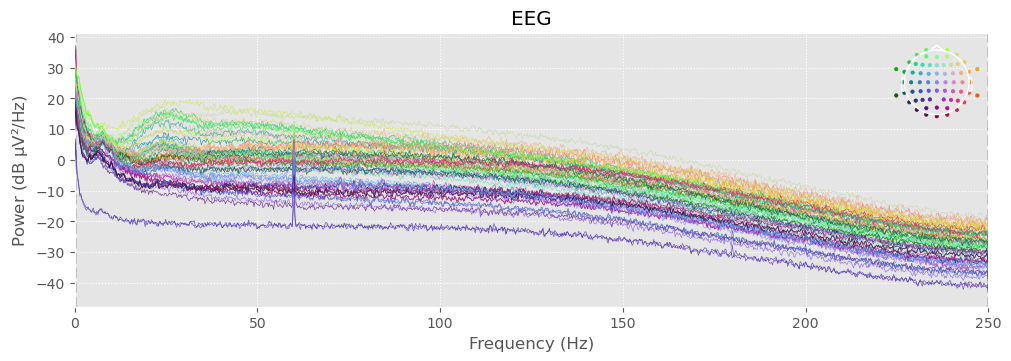

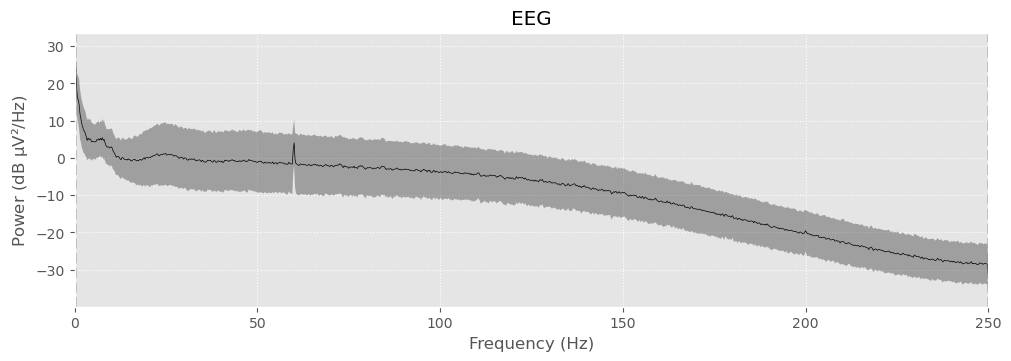

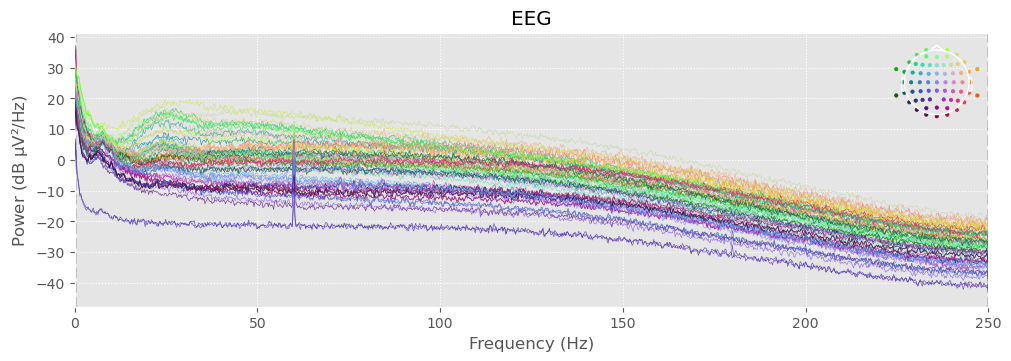

In [7]:
# Quick visual examination

# Plot Time Series
# eeg_dataset_raw.plot(duration=10, n_channels=16, clipping=None)

# Average PSD All Channels
eeg_dataset_raw.compute_psd().plot(average=True)
eeg_dataset_raw.compute_psd().plot()



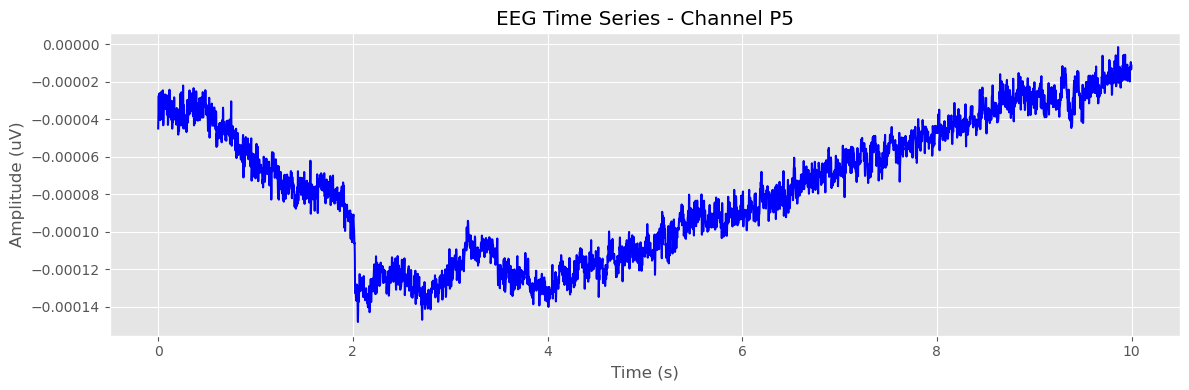

In [8]:
# Visual on a selected channel

# Settings for exploring an example channel of data
fs = eeg_dataset_raw.info['sfreq']
ch_label = 'P5'
t_start = 0
t_stop = int(t_start + (10 * fs))

# Extract an example channel
sig, times = eeg_dataset_raw.get_data(mne.pick_channels(eeg_dataset_raw.ch_names, [ch_label]),
                          start=t_start, stop=t_stop,
                          return_times=True)
sig = np.squeeze(sig)

plt.figure(figsize=(12, 4))
plt.plot(times, sig, color='blue')
plt.title(f"EEG Time Series - Channel {ch_label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (uV)")
plt.tight_layout()
plt.show()


# 2. EEG Preprocessing


In [9]:
# TODO: Add filtering
# TODO: Add ICA

# 3. Power Spectrum



In [10]:
# Calculate the Power Spectrum - MNE
method = 'welch'
fmin = 1
fmax = np.inf

print(f"Computing power spectrum using {method} method...")
spectrum = eeg_dataset_raw.compute_psd(method=method, fmin=fmin, fmax=fmax)
x_freqs = spectrum.freqs
x_powers = spectrum.get_data(return_freqs=False)
print(spectrum.info)

Computing power spectrum using welch method...
Effective window size : 4.096 (s)
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>


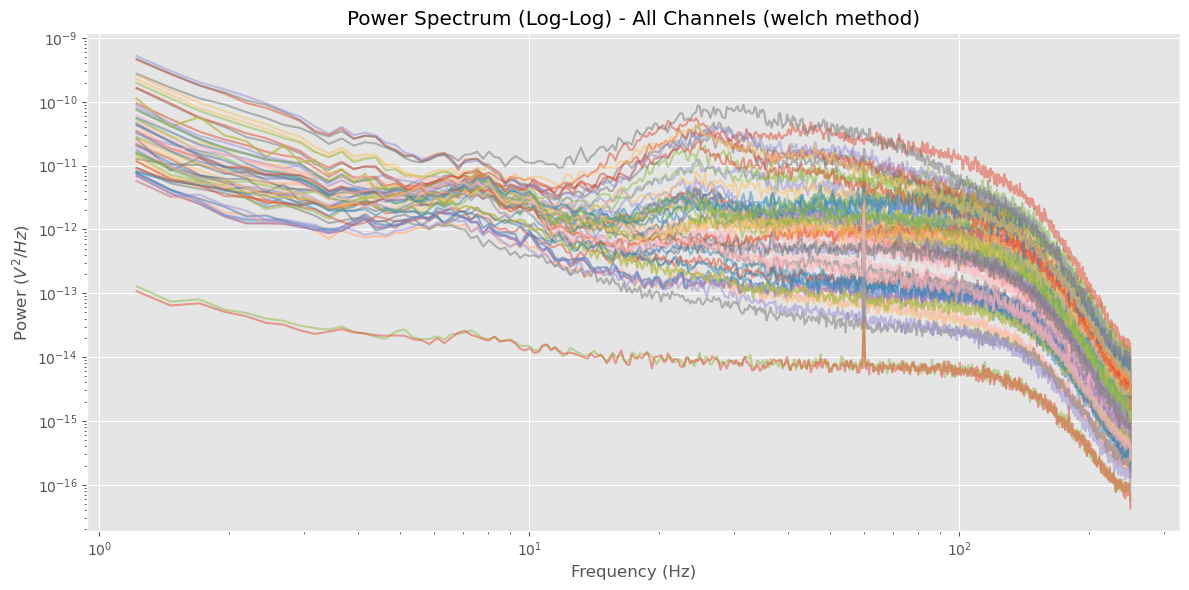

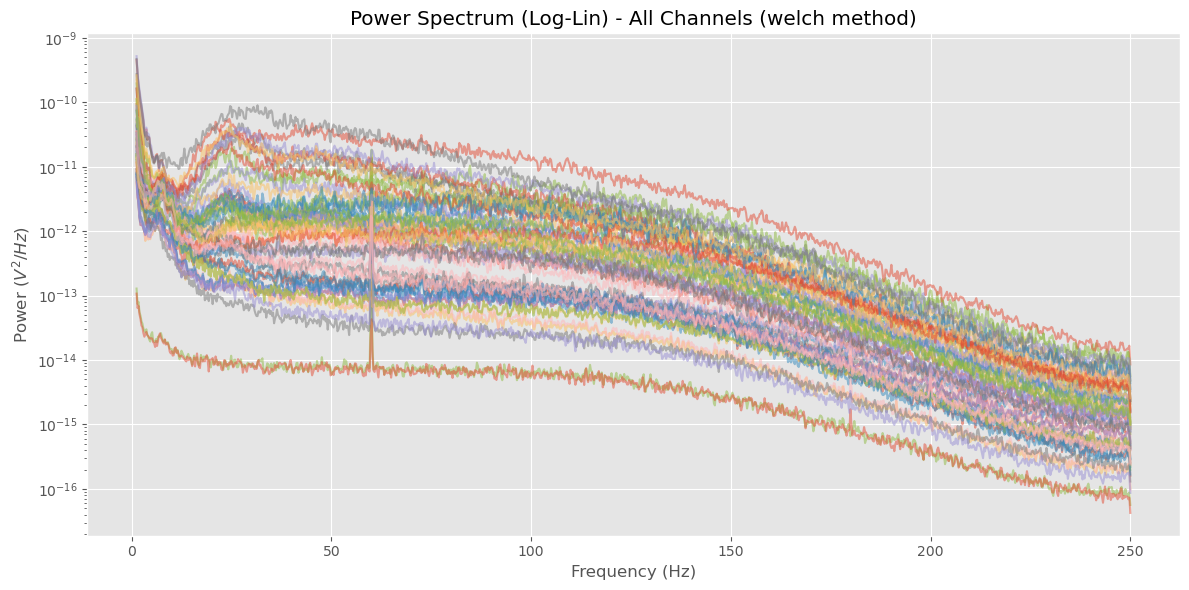

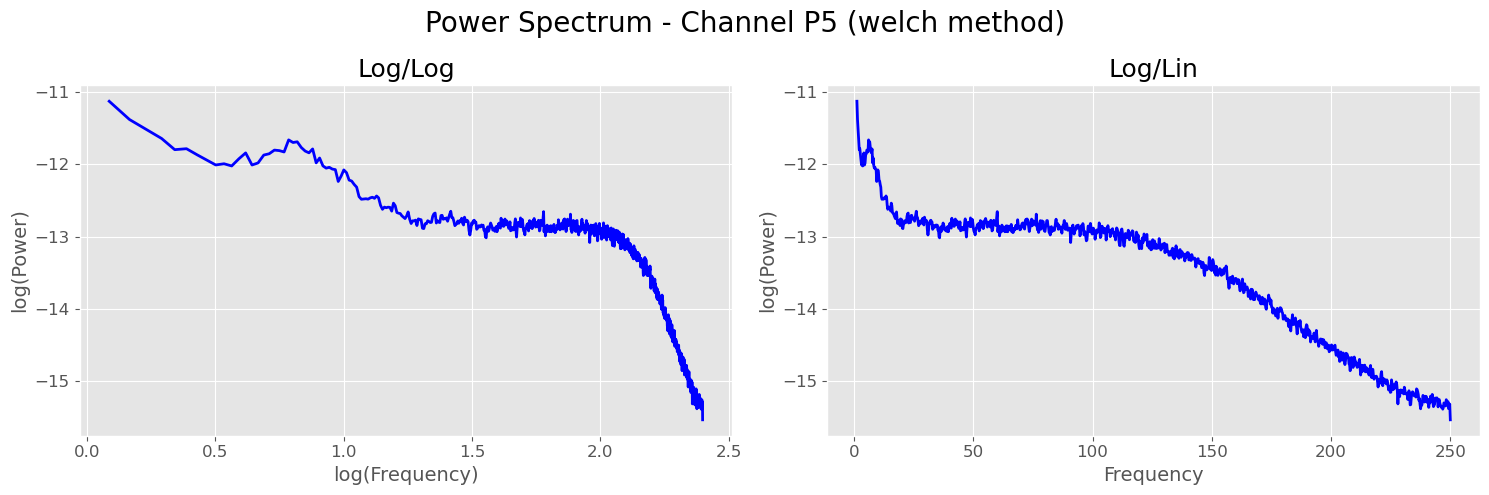

In [39]:

# Log-log plot for all channels
plt.figure(figsize=(12, 6))
for idx, ch in enumerate(eeg_dataset_raw.ch_names):
    plt.loglog(x_freqs, x_powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
plt.title(f"Power Spectrum (Log-Log) - All Channels ({method} method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power ($V^2/Hz$)")
plt.tight_layout()
plt.show()

# Log-lin plot for all channels
plt.figure(figsize=(12, 6))
for idx, ch in enumerate(eeg_dataset_raw.ch_names):
    plt.semilogy(x_freqs, x_powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
plt.title(f"Power Spectrum (Log-Lin) - All Channels ({method} method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power ($V^2/Hz$)")
plt.tight_layout()
plt.show()

# A selected channel
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle(f'Power Spectrum - Channel {ch_label} ({method} method)', fontsize=20)
ax0.set_title('Log/Log')
ax1.set_title('Log/Lin')

# ax0.set_xlabel('test')
plot_spectra(x_freqs, x_powers[eeg_dataset_raw.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
plot_spectra(x_freqs, x_powers[eeg_dataset_raw.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')

plt.show()


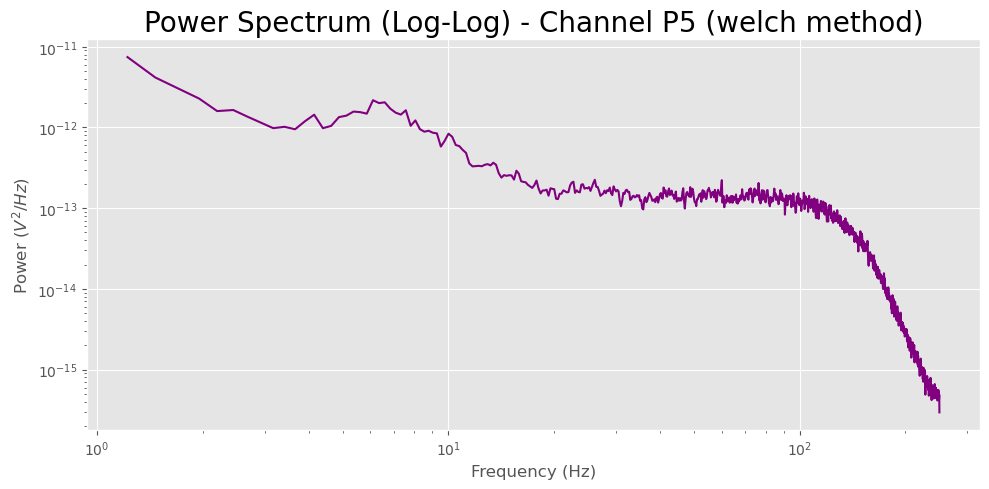

In [33]:
# Log-log plot for a selected channel
ch_label = 'P5'

plt.figure(figsize=(10, 5))
plt.title(f'Power Spectrum (Log-Log) - Channel {ch_label} ({method} method)', fontsize=20)
plt.loglog(x_freqs, x_powers[eeg_dataset_raw.ch_names.index(ch_label)], color='purple')
# plt.title(f"Power Spectrum (Log-Log) - Channel {ch_label} ({method} method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power ($V^2/Hz$)")
plt.tight_layout()
plt.show()

In [13]:
# # Compare with NeuroDSP

# # Import functions to compute power spectra, the Power Spectral Density (PSD), ie the frequency domain representation of a neural time series / time domain
# from neurodsp.spectral import compute_spectrum

# # Import functions for plotting
# from neurodsp.utils import create_times
# from neurodsp.plts import plot_time_series, plot_power_spectra, plot_timeseries_and_spectra

# # Import functions from specparam(fooof)
# from fooof.utils import trim_spectrum

# # Calculate the power spectrum using NeuroDSP
# freqs, powers = compute_spectrum(sig, fs)

# # Also an example with a subset of the full time series, frequency range
# # And identifying the bigest peak
# freq_range = [1, 75]
# trim_freqs, trim_powers = trim_spectrum(freqs, powers, freq_range)
# peak_frq = trim_freqs[np.argmax(trim_powers)]
# print(f'Peak Frequency: {peak_frq} Hz')

# fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# fig.suptitle('NeuroDSP - Power Spectra', fontsize=20)
# ax0.set_title('Full Range')
# ax1.set_title(f'Range: {freq_range}')

# plot_power_spectra(freqs, powers, ax=ax0, colors='blue')
# plot_power_spectra(trim_freqs, trim_powers, 
#                    minorticks=False, xticks=[1, 5, 10, 25, 75], xticklabels=[1, 5, 10, 25, 75], ax=ax1, colors='blue')
# ax1.plot(trim_freqs[np.argmax(trim_powers)], np.max(trim_powers), 'r.', ms=12)

# plt.show()

# 4. Spectral Parameterisation


Extracting Periodic & Aperiodic Components
For 63 channels
Frequency resolution: 0
Peak width limits: [1, 12]
Min peak height: 0.05 and max peaks: 25
Range: [1, 75] out of 1 to 250
Aperiodic Mode: fixed
Channel: 0 - Fp1
Channel: 1 - Fz
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.4394, 0.2493              

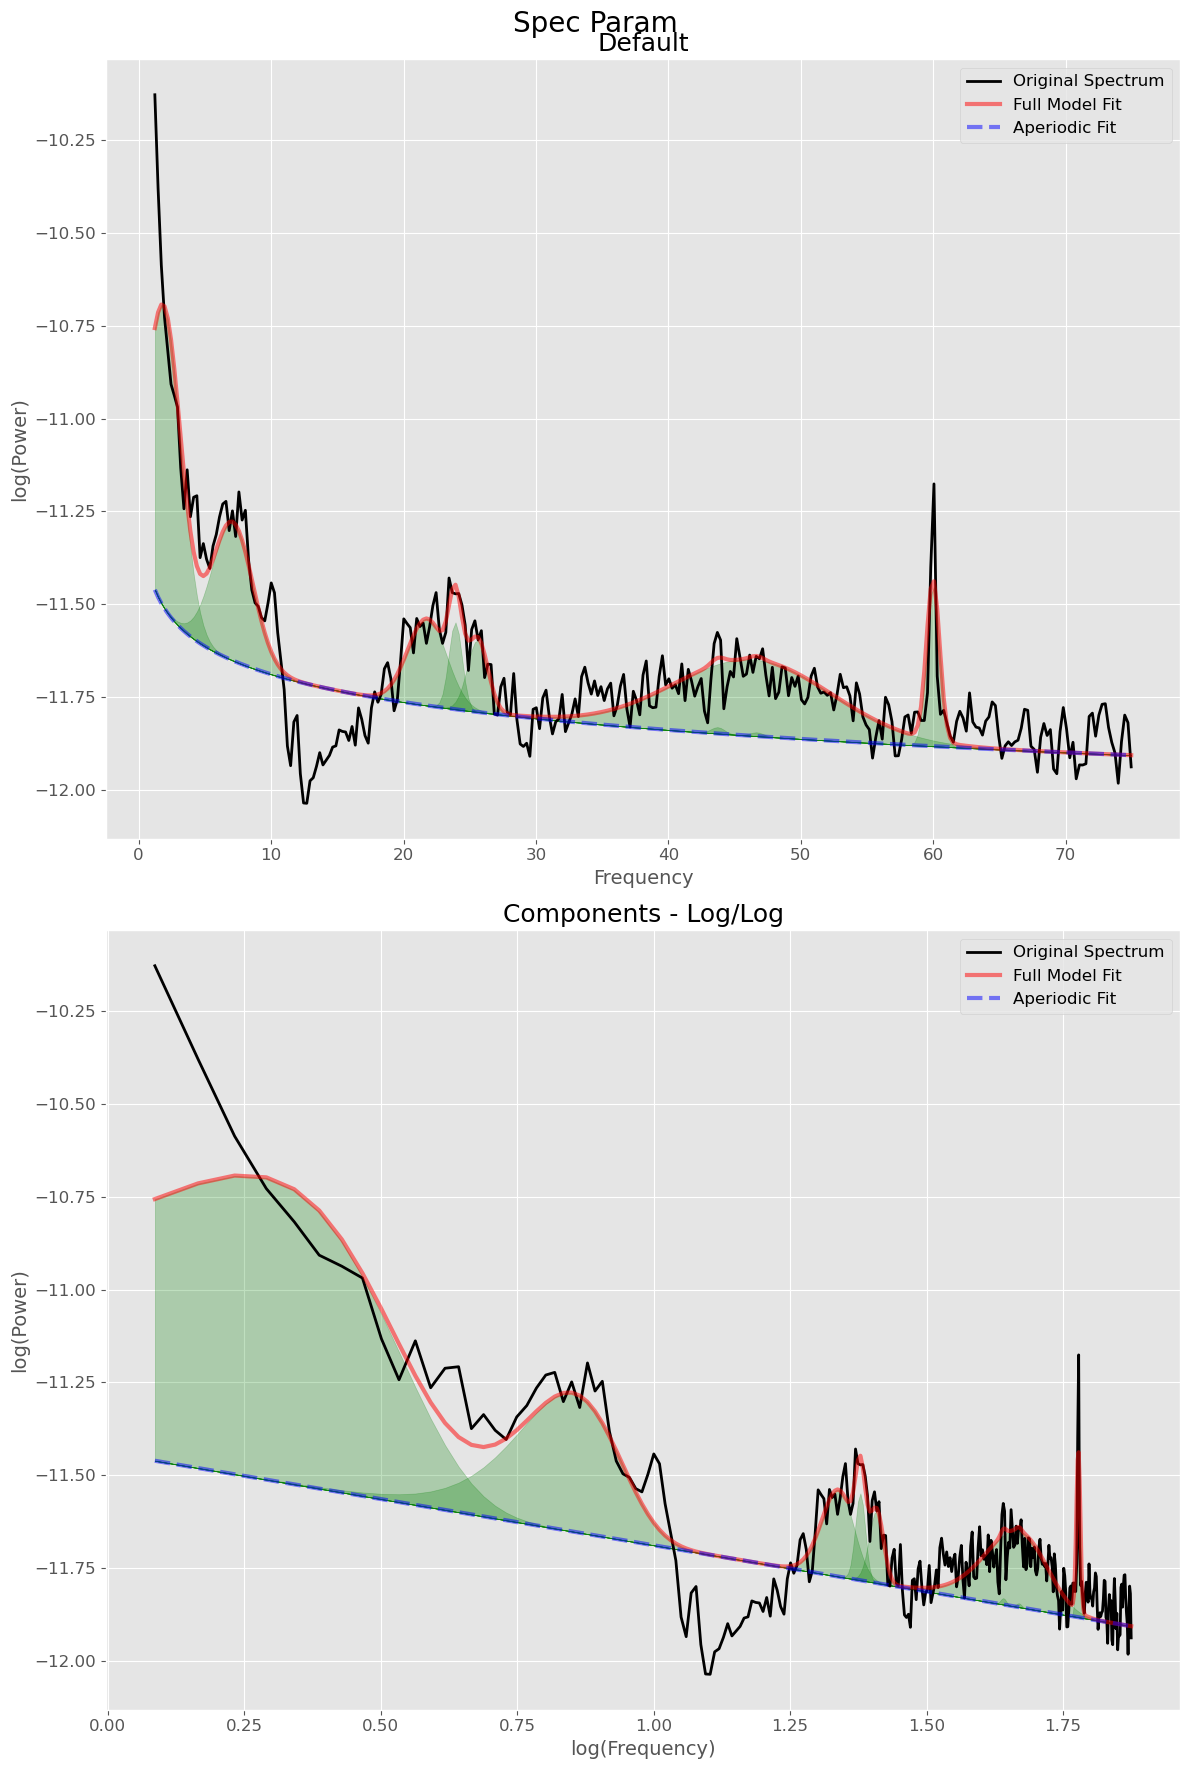

In [14]:
# Determine Periodic & Aperiodic Components - Individual Channels

# Parameters for SpecParam
freq_resolution = x_freqs[1] - x_freqs[0]
peak_width_limits = [int(math.ceil(2 * freq_resolution)), 12]
min_peak_height = 0.05
max_n_peaks = 25
fit_freq_range = [1, 75]
aperiodic_mode = 'fixed'

n_channels = x_powers.shape[0]

print('Extracting Periodic & Aperiodic Components')
print(f'For {n_channels} channels')
print(f'Frequency resolution: {freq_resolution:.0f}')
print(f'Peak width limits: [{peak_width_limits[0]:.0f}, {peak_width_limits[1]:.0f}]')
print(f'Min peak height: {min_peak_height:.2f} and max peaks: {max_n_peaks}')
print(f'Range: {fit_freq_range} out of {x_freqs.min():.0f} to {x_freqs.max():.0f}')
print(f'Aperiodic Mode: {aperiodic_mode}')

# Initialize FOOOF model
fm = FOOOF(peak_width_limits=peak_width_limits, 
           max_n_peaks=max_n_peaks, 
           min_peak_height=min_peak_height,
           aperiodic_mode=aperiodic_mode)

# Results Dictionary
periodic_params = {
    'center_frequency': [],
    'power': [],
    'bandwidth': []
}
aperiodic_params = {
    'offset': [],
    'exponent': []
}

# Iterate trough each channel
for next_channel in range(n_channels):
    if next_channel >= 2:
        break
    print(f'Channel: {next_channel} - {eeg_dataset_raw.ch_names[next_channel]}')

    # Fit FOOOF model
    fm.fit(x_freqs, x_powers[next_channel], fit_freq_range)

    # TODO: Save with each Channel? Rather than a single list?
    # Save periodic results for each peak
    if fm.peak_params_.size > 0:
        for peak in fm.peak_params_:
            periodic_params['center_frequency'].append(peak[0])
            periodic_params['power'].append(peak[1])
            periodic_params['bandwidth'].append(peak[2])
    else:
        # If no peaks found, append NaN to keep array lengths consistent
        periodic_params['center_frequency'].append(np.nan)
        periodic_params['power'].append(np.nan)
        periodic_params['bandwidth'].append(np.nan)

    # Save aperiodic parameters
    aperiodic_params['offset'].append(fm.aperiodic_params_[0])
    aperiodic_params['exponent'].append(fm.aperiodic_params_[-1])

# Just visualise / check the last fit
fm.print_results()

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))
fig.suptitle('Spec Param', fontsize=20)
ax0.set_title('Default')
ax1.set_title('Components - Log/Log')
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
plt.show()



In [15]:
# Determine Preiodic & Aperiodic Components - For a Group of Channels

# For group of spectra
n_channels = x_powers.shape[0]
n_frequencies = x_powers.shape[1]
freq_resolution = x_freqs[1] - x_freqs[0]
print(f'For Spectra Group:')
print(f'- {n_channels} channels & {n_frequencies} frequencies')
print(f'- Frequency Range: {x_freqs.min():.0f} to {x_freqs.max():.0f} Hz')
print(f'- Frequency resolution {freq_resolution:.2f} Hz')

# Parameters for SpecParam
max_peak_width = 12
min_peak_height = 0.05
max_n_peaks = 25
fit_freq_range = [1, 75]
aperiodic_mode = 'fixed'

peak_width_limits = [int(math.ceil(2 * freq_resolution)), max_peak_width]
print('Extracting Periodic & Aperiodic Components with Parameters:')
print(f'- Peak width limits: [{peak_width_limits[0]:.0f}, {peak_width_limits[1]:.0f}]')
print(f'- Min peak height: {min_peak_height:.2f}')
print(f'- Max peaks: {max_n_peaks}')
print(f'- Range: {fit_freq_range}')
print(f'- Aperiodic Mode: {aperiodic_mode}')

# Initialize FOOOF model
fg = FOOOFGroup(peak_width_limits=peak_width_limits, 
                max_n_peaks=max_n_peaks, min_peak_height=min_peak_height,
                aperiodic_mode=aperiodic_mode)

# Fit the group of n spectra
fg.fit(x_freqs, x_powers, fit_freq_range, progress='tqdm.notebook')

For Spectra Group:
- 63 channels & 1020 frequencies
- Frequency Range: 1 to 250 Hz
- Frequency resolution 0.24 Hz
Extracting Periodic & Aperiodic Components with Parameters:
- Peak width limits: [1, 12]
- Min peak height: 0.05
- Max peaks: 25
- Range: [1, 75]
- Aperiodic Mode: fixed


Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 63                             
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

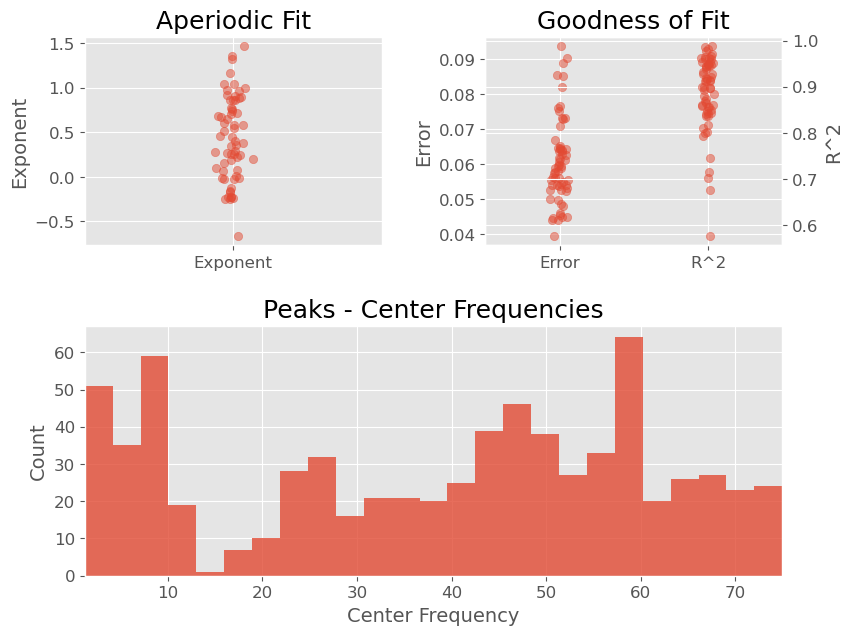

In [16]:
# Examine the group results
fg.print_results()
fg.plot()
plt.show()
# fg.save_report('FOOOFGroup_report')


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.4394, 0.2493                                         
                                                                                                  
                                       9 peaks were found:                                        
          

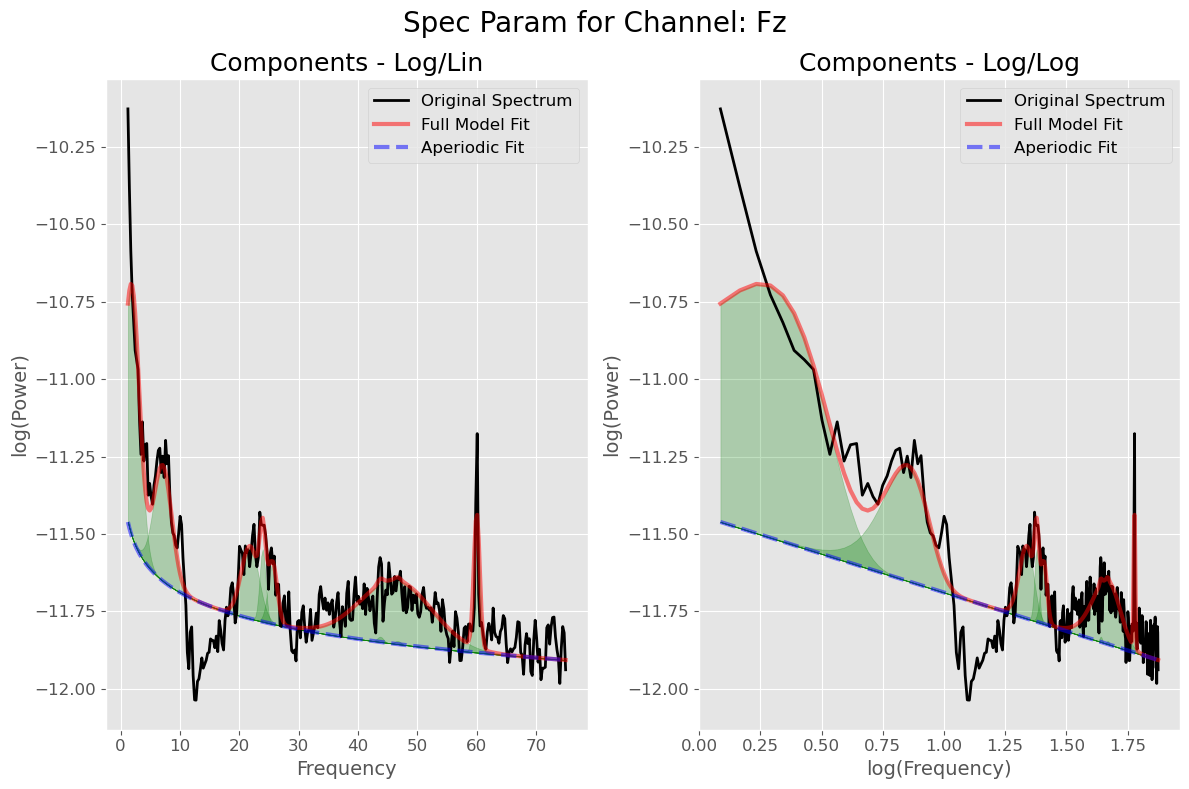

In [17]:
# Visualise the fit for a sample single channel within the group
channel_indx = 1
ch_label = eeg_dataset_raw.ch_names[channel_indx]

fm = fg.get_fooof(ind=channel_indx, regenerate=True)

fm.print_results()

# fm.plot()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
fig.suptitle(f'Spec Param for Channel: {ch_label}', fontsize=20)
ax0.set_title('Components - Log/Lin')
ax1.set_title('Components - Log/Log')
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
plt.show()


In [18]:
# print(fg.group_results[0:2])

In [19]:

channels_max_n = 63
peaks_max_n = 10

aperiodics = fg.get_params('aperiodic_params')
periodics = fg.get_params('peak_params')

# For each channel, add the paramters to the features dictionary
features = {'subject_id': 42, 'age': 21, 'gender': 'male', 'pd': 0}

for next_channel in range(aperiodics.shape[0]):
    features[f'ch{next_channel}_aperiodic_offset'] = aperiodics[next_channel, 0]
    features[f'ch{next_channel}_aperiodic_exponent'] = aperiodics[next_channel, 1]

    # For up to the max peaks, get periodic components
    peaks_ch = periodics[periodics[:, 3] == next_channel]
    peaks_found = peaks_ch.shape[0]
    if peaks_found > peaks_max_n:
        print(f'WARNING: Peaks found: {peaks_found} but only {peaks_max_n} saved')
    for next_peak in range(peaks_max_n):
        if peaks_found > next_peak:
            features[f'ch{next_channel}_pk{next_peak}_periodic_CF'] = peaks_ch[next_peak, 0]
            features[f'ch{next_channel}_pk{next_peak}_periodic_PW'] = peaks_ch[next_peak, 1]
            features[f'ch{next_channel}_pk{next_peak}_periodic_BW'] = peaks_ch[next_peak, 2]
        else:
            features[f'ch{next_channel}_pk{next_peak}_periodic_CF'] = float('nan')
            features[f'ch{next_channel}_pk{next_peak}_periodic_PW'] = float('nan')
            features[f'ch{next_channel}_pk{next_peak}_periodic_BW'] = float('nan')

df_subject_features = pd.DataFrame([features])




In [20]:
import pandas as pd

subject_id = 42
aperiodics = fg.get_params('aperiodic_params')
periodics = fg.get_params('peak_params')

# Prepare a dictionary to hold all features
features = {}

# Add aperiodic parameters for each channel
for ch in range(aperiodics.shape[0]):
    features[f'aperiodic_offset_ch{ch}'] = aperiodics[ch, 0]
    features[f'aperiodic_exponent_ch{ch}'] = aperiodics[ch, 1]

# Add periodic parameters: flatten so each peak per channel is a separate column
# We'll use only the first peak per channel for simplicity (or NaN if none)
for ch in range(n_channels):
    peaks_ch = periodics[periodics[:, 3] == ch]
    if peaks_ch.shape[0] > 0:
        features[f'periodic_CF_ch{ch}'] = peaks_ch[0, 0]
        features[f'periodic_PW_ch{ch}'] = peaks_ch[0, 1]
        features[f'periodic_BW_ch{ch}'] = peaks_ch[0, 2]
    else:
        features[f'periodic_CF_ch{ch}'] = float('nan')
        features[f'periodic_PW_ch{ch}'] = float('nan')
        features[f'periodic_BW_ch{ch}'] = float('nan')

# Create DataFrame with subject as index
df_features = pd.DataFrame(features, index=[subject_id])
df_features

,aperiodic_offset_ch0,aperiodic_exponent_ch0,aperiodic_offset_ch1,aperiodic_exponent_ch1,aperiodic_offset_ch2,aperiodic_exponent_ch2,aperiodic_offset_ch3,aperiodic_exponent_ch3,aperiodic_offset_ch4,aperiodic_exponent_ch4,...,periodic_BW_ch59,periodic_CF_ch60,periodic_PW_ch60,periodic_BW_ch60,periodic_CF_ch61,periodic_PW_ch61,periodic_BW_ch61,periodic_CF_ch62,periodic_PW_ch62,periodic_BW_ch62
42,-10.965106,0.550192,-11.439397,0.249328,-11.560013,0.200874,-11.387814,-0.171096,-11.0549,0.653781,...,2.334959,2.162109,0.864402,2.21249,1.906284,0.820677,2.545337,7.713016,0.507132,3.944369


In [21]:
import pandas as pd

subject_id = 42
aperiodics = fg.get_params('aperiodic_params')
periodics = fg.get_params('peak_params')

# Create a MultiIndex for (subject, channel)
channels = range(aperiodics.shape[0])
index = pd.MultiIndex.from_product([[subject_id], channels], names=['subject', 'channel'])

# Build a DataFrame for aperiodic parameters
df = pd.DataFrame(aperiodics, columns=['offset', 'exponent'], index=index)

# Convert to Series with MultiIndex
series = df.stack()
series.name = 'value'
series

subject  channel          
42       0        offset     -10.965106
                  exponent     0.550192
         1        offset     -11.439397
                  exponent     0.249328
         2        offset     -11.560013
                                ...    
         60       exponent     0.102280
         61       offset     -11.420415
                  exponent     0.260595
         62       offset     -10.878180
                  exponent     1.047090
Name: value, Length: 126, dtype: float64

In [22]:
import pandas as pd
import gc

# Save aperiodic components into a temp DF
aperiodics = fg.get_params('aperiodic_params')
df_aperiodic = pd.DataFrame(aperiodics, columns=['offset', 'exponent'])

# Save periodic components into a temp DF
periodics = fg.get_params('peak_params')
periodics_flat = []
for row in periodics:
    periodics_flat.append({
        'channel': int(row[3]),
        'CF': row[0],
        'PW': row[1],
        'BW': row[2]
    })
df_periodic = pd.DataFrame(periodics_flat)

# del aperiodics, df_aperiodic
# gc.collect()



In [23]:
import pandas as pd

# Obtain all the periodic and aperiodic component parameters & add to the features dataframe

aperiodics = fg.get_params('aperiodic_params')
# Create a DataFrame for aperiodic parameters
df_aperiodic = pd.DataFrame(aperiodics, columns=['offset', 'exponent'])

# Create a DataFrame for periodic parameters (flattened, one row per peak per channel)
periodics_flat = []
for ch_idx, peaks in enumerate(periodics):
    for peak in peaks:
        periodics_flat.append({
            'channel': ch_idx,
            'CF': peak[0],
            'PW': peak[1],
            'BW': peak[2]
        })
df_periodic = pd.DataFrame(periodics_flat)

# Combine into a single DataFrame (if you want one row per channel, join on channel index)
features_df = df_aperiodic.copy()
features_df['channel'] = features_df.index
# Optionally, merge periodic features (e.g., first peak per channel)
if not df_periodic.empty:
    first_peak_df = df_periodic.groupby('channel').first().reset_index()
    features_df = features_df.merge(first_peak_df, on='channel', how='left')

periodics = fg.get_params('peak_params')


# 'CF', 'PW', 'BW', 
# 'offset', 'knee', 'exponent'


IndexError: invalid index to scalar variable.

# 5. Features Collation & Save
